In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import os, sys
cwd = os.getcwd()

api_path_сifar = os.path.join(cwd, '..', 'tools', 'cifar10_utils')
api_path_sampling = os.path.join(cwd, '..', 'tools', 'sampling_utils')
models_cifar_path = os.path.join(cwd, '..', 'models_cifar10')
#models_2d_path = os.path.join(cwd, '..', 'models_25gaussians', 'wasserstein')
sys.path.append(api_path_сifar)
sys.path.append(api_path_sampling)

In [57]:
import numpy as np
import time
import random
import glob
import importlib
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from distributions import IndependentNormal
import torchvision.transforms as transforms

from functools import partial

from dataloader import get_loader
from trainer import Trainer
from discriminator import Discriminator
from generator import Generator
from params_cifar10 import args
from general_utils import to_var, DotDict, to_np

from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling, 
                          mala_sampling,
                          xtry_langevin_sampling,
                          tempered_transitions_sampling,
                          gan_energy)

from metrics import inception_score
from dataloader import GenDataset

In [26]:
args.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

G = Generator(args).to(args.device)
D = Discriminator(args).to(args.device)

In [27]:
models_regexp = os.path.join(models_cifar_path, "*.pth")
models_name = [f for f in glob.glob(models_regexp)][0]

In [28]:
ckpt = torch.load(models_name)
G.load_state_dict(ckpt['G'])
D.load_state_dict(ckpt['D'])

<All keys matched successfully>

In [29]:
G.eval()
D.eval()

Discriminator(
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
    (2): SpectralNorm(
      (module): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (3): LeakyReLU(negative_slope=0.1)
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
    (2): SpectralNorm(
      (module): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (3): LeakyReLU(negative_slope=0.1)
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
    (2): SpectralNorm(
      (module): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (3): LeakyReLU(negative_slope=0.1)

In [30]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)
random.seed(args.random_seed)
nsamples = 64
fixed_z = torch.randn(nsamples, G.z_dim)

In [31]:
fixed_z_var = to_var(fixed_z, device = args.device)
samples = G(fixed_z_var)
samples_normalized = ((samples + 1) / 2).clamp(0, 1)

In [32]:
images_torch = samples_normalized.data

In [34]:
images_torch.shape

torch.Size([64, 3, 32, 32])

In [36]:
def plot_images(images_torch):
    batch_size_sample = images_torch.shape[0]
    numpy_images = images_torch.detach().cpu().numpy().transpose(0, 2, 3, 1)
    numpy_images = (numpy_images - numpy_images.min())/(numpy_images.max() - numpy_images.min())
    nrow = int(batch_size_sample**0.5)
    fig = plt.figure(figsize=(20, 20))
    axes = fig.subplots(nrow, nrow)
    for k in range(batch_size_sample):
        i = k // nrow
        j = k % nrow
        #axes[i][j].imshow(np.clip(numpy_images[k], 0, 1))
        axes[i][j].imshow(numpy_images[k])
        axes[i][j].axis('off')
    plt.show()

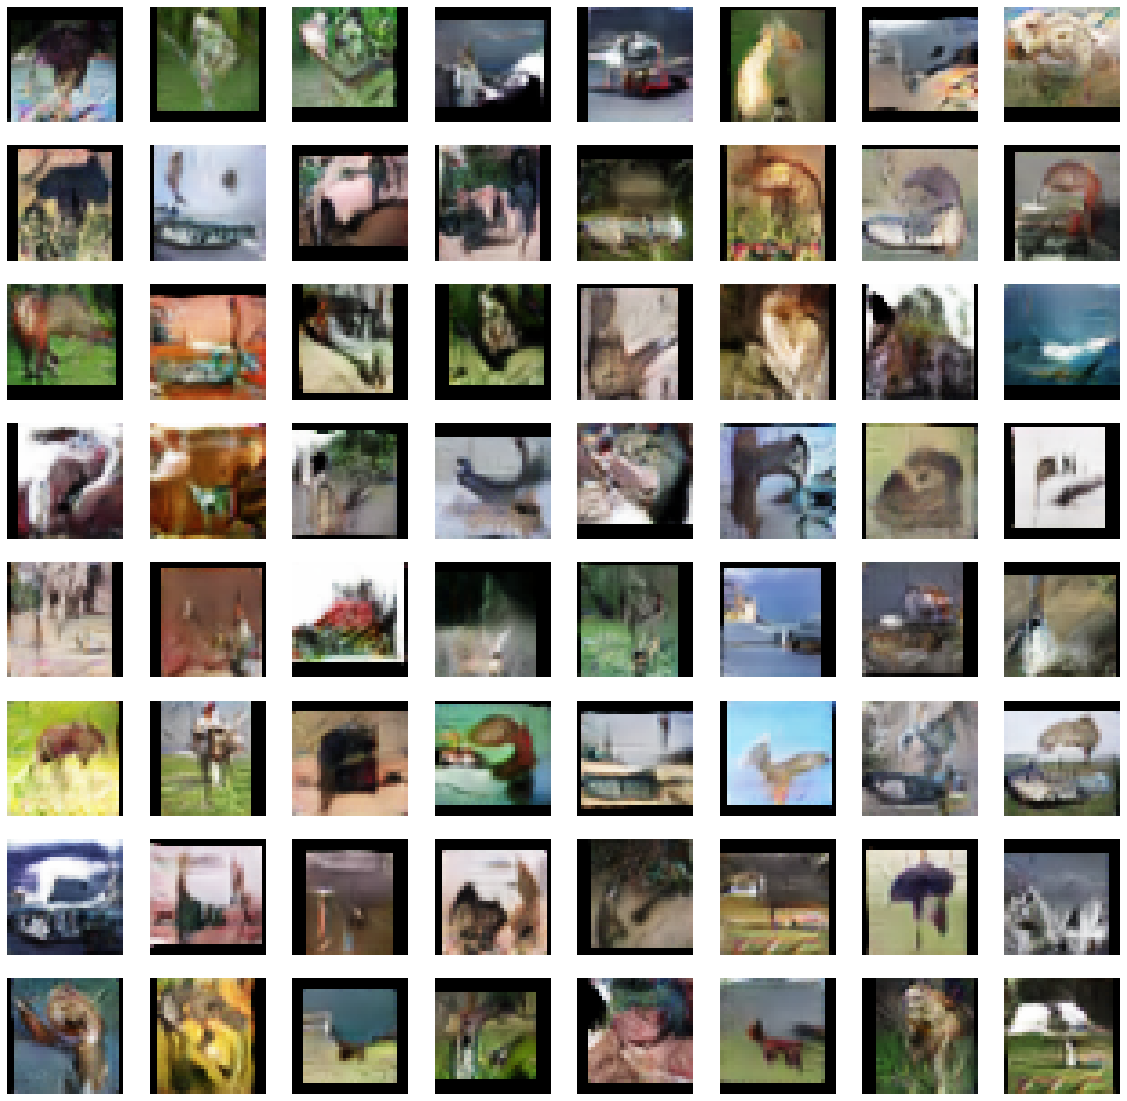

In [37]:
plot_images(images_torch)

In [75]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)
random.seed(args.random_seed)
nsamples = 64
fixed_z = torch.randn(nsamples, G.z_dim)
fixed_z_var = to_var(fixed_z, device = args.device)
fake_imgs = G(fixed_z_var).detach()

D_outputs = D(fake_imgs)

In [76]:
print(D_outputs.cpu().data)

tensor([-1.2128, -1.1048, -0.8892, -1.0971, -1.4525, -0.5750, -1.4660, -1.1573,
        -1.1246, -1.2205, -0.9563, -0.8065, -1.1288, -1.1482, -1.3316, -1.0993,
        -1.1699, -1.6154, -0.8331, -0.6730, -1.1121, -1.0855, -0.9562, -0.4399,
        -1.0821, -0.7122, -1.3308, -1.0505, -0.6062, -1.2072, -1.2933, -1.5218,
        -1.5749, -1.2286, -1.0713, -0.8055, -0.7433, -1.4304, -0.9809, -0.9048,
        -2.0242, -1.0409, -1.3007, -1.1661, -1.4891, -1.3517, -0.9026, -1.4983,
        -1.2008, -1.1853, -1.1650, -1.2368, -0.8152, -1.5356, -1.6077, -1.3199,
        -0.6747, -1.4228, -1.4558, -1.0220, -1.1528, -1.2844, -0.6392, -1.2653])


In [51]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)
random.seed(args.random_seed)
num_samples = 50000
dataset = GenDataset(G, num_samples)

In [53]:
time = start
score_mean, score_std = inception_score(dataset, device, args.batch_size, True)

Start to make predictions
Start to compute KL divergence


In [54]:
print(f"inception score = {score_mean}")

inception score = 4.132783400060406


In [97]:
score_std

0.058822528855123846

In [58]:
class LatentFixDataset(torch.utils.data.Dataset):
    """Dataset for Generator
    """
    def __init__(self, latent_arr, G, device, nsamples):
        self.latent_arr = latent_arr
        self.G = G
        self.nsamples = nsamples
        self.transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),
                                    (0.229, 0.224, 0.225))
        ])

    def __getitem__(self, index):
        z = to_var(self.latent_arr[index], self.G.device)
        return self.transform(np.squeeze(to_np(self.denorm(self.G(z)).permute(0, 2, 3, 1))))

    def __len__(self):
        return self.nsamples

    def denorm(self, x):
        # For fake data generated with tanh(x)
        x = (x + 1) / 2
        return x.clamp(0, 1)

# ULA

In [65]:
z_dim = G.z_dim
device = args.device
loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

log_prob = True
normalize_to_0_1 = True
target_gan = partial(gan_energy,
                     generator = G, 
                     discriminator = D, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob)

In [66]:
def grad_energy(point, target, x=None):
    point = point.detach().requires_grad_()
    if x is not None:
        energy = -target(z=point, x=x)
    else:
        energy = -target(point)
    grad = torch.autograd.grad(energy.sum(), point)[0]
    return energy, grad 

def langevin_dynamics(z, target, proposal, n_steps, grad_step, eps_scale):
    z_sp = []
    batch_size, z_dim = z.shape[0], z.shape[1]

    for _ in range(n_steps):
        z_sp.append(z)
        eps = eps_scale*proposal.sample([batch_size])

        E, grad = grad_energy(z, target, x=None)
        z = z - grad_step * grad + eps        
        z = z.data
        z.requires_grad_(True)
    z_sp.append(z)
    return z_sp

In [67]:
def langevin_sampling(target, proposal, n_steps, grad_step, eps_scale, n, batch_size):
    z_last = []
    zs = []
    z = proposal.sample([batch_size])
    
    for i in tqdm(range(0, n, batch_size)):
        z = proposal.sample([batch_size])
        z.requires_grad_(True)
        z_sp = langevin_dynamics(z, target, proposal, n_steps, grad_step, eps_scale)
        last = z_sp[-1].data.cpu().numpy()
        z_last.append(last)
        zs.append(np.stack([o.data.cpu().numpy() for o in z_sp], axis=0))

    z_last_np = np.asarray(z_last).reshape(-1, z.shape[-1])
    zs = np.stack(zs, axis=0)
    return z_last_np, zs

In [70]:
batch_size = 1000
n = 50000
n_steps = 100
grad_step = 0.01
eps_scale = (2*grad_step)**0.5
z_last_np, zs = langevin_sampling(target_gan, proposal, n_steps, grad_step, eps_scale, n, batch_size)

100%|██████████| 50/50 [31:24<00:00, 37.69s/it]


In [71]:
nsamples = len(z_last_np)
latent_arr = torch.FloatTensor(z_last_np)
latent_dataset = LatentFixDataset(latent_arr, G, device, nsamples)

In [73]:
score_mean_langevin, score_std_langevin = inception_score(latent_dataset, device, args.batch_size, True)

Start to make predictions
Start to compute KL divergence


In [74]:
print(f"inception score for Langevin = {score_mean_langevin}")

inception score for Langevin = 4.165590104472066


In [98]:
score_std_langevin

0.03437082207021135

In [115]:
batch_size = 1000
n = 50000
n_steps = 100
grad_step = 0.001
eps_scale = 0.1
z_last_np_2, zs = langevin_sampling(target_gan, proposal, n_steps, grad_step, eps_scale, n, batch_size)

100%|██████████| 50/50 [31:20<00:00, 37.61s/it]


In [116]:
nsamples = len(z_last_np_2)
latent_arr_2 = torch.FloatTensor(z_last_np_2)
latent_dataset_2 = LatentFixDataset(latent_arr_2, G, device, nsamples)

In [117]:
score_mean_langevin_2, score_std_langevin_2 = inception_score(latent_dataset_2, device, args.batch_size, True)

Start to make predictions
Start to compute KL divergence


In [118]:
print(f"inception score for Langevin = {score_mean_langevin_2}")

inception score for Langevin = 3.9287655061326148


In [ ]:
score_std_langevin_2

In [103]:
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)
random.seed(args.random_seed)
nsamples = 64
fixed_z = torch.randn(nsamples, G.z_dim)
fixed_z_var = to_var(fixed_z, device = args.device)
n_steps = 100
grad_step = 0.001
eps_scale = 0.1

z_sp = langevin_dynamics(fixed_z_var, target_gan, proposal, n_steps, grad_step, eps_scale)

In [104]:
last = z_sp[-1].data.cpu().numpy()

In [105]:
last_tensor = torch.FloatTensor(last)
last_var = to_var(last_tensor, device = args.device)
samples_last = G(last_var)
samples_normalized_last = ((samples_last + 1) / 2).clamp(0, 1)
images_torch_langevin = samples_normalized_last.data

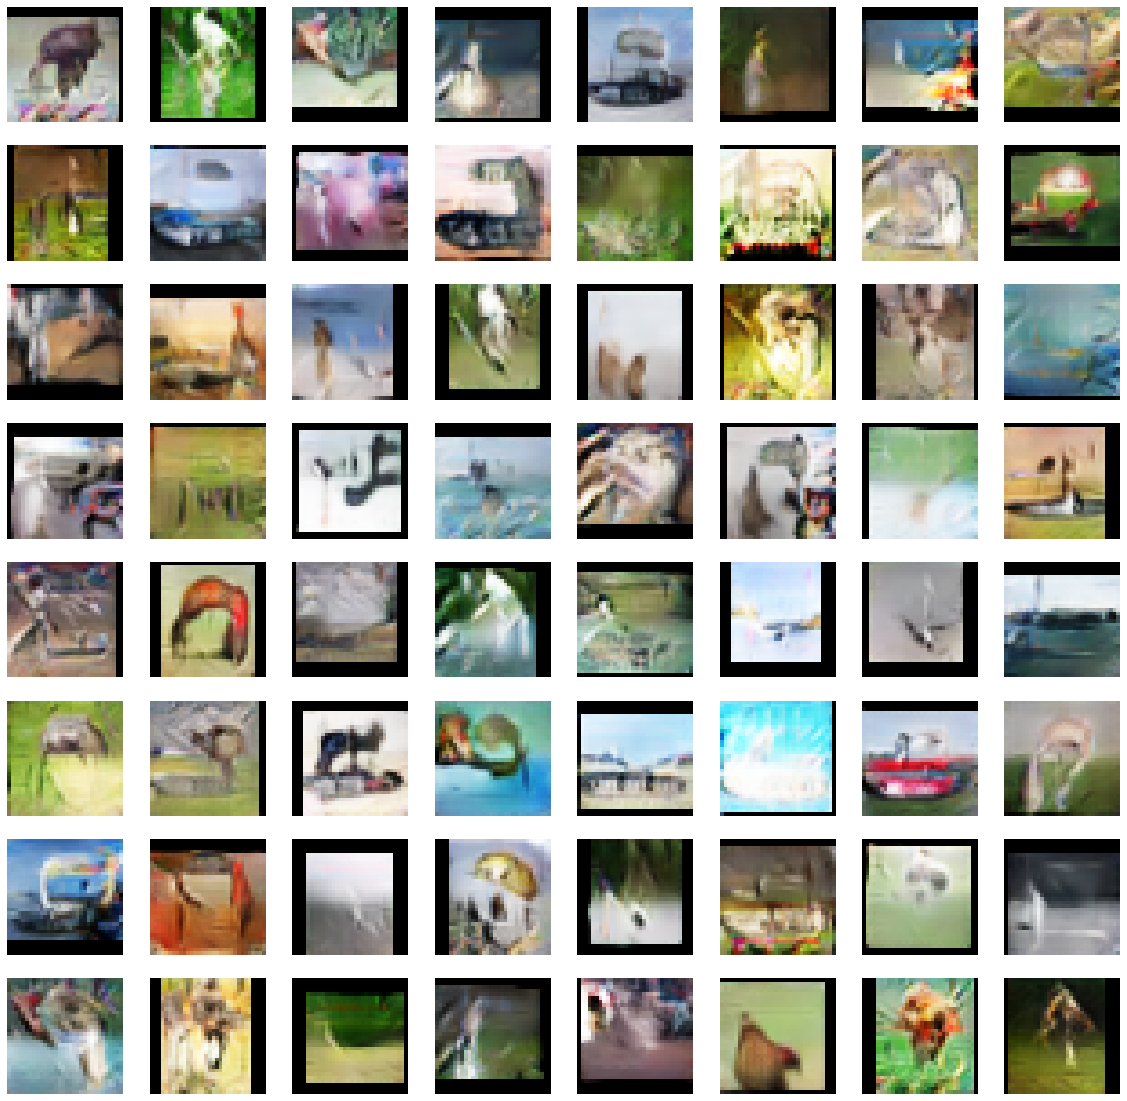

In [106]:
plot_images(images_torch_langevin)

In [111]:
D_outputs_langevin = D(images_torch_langevin)

In [112]:
print(D_outputs_langevin.cpu().data)

tensor([-0.6242, -0.9844,  0.3910, -0.5712, -0.4992, -0.7435,  0.3759, -0.8248,
        -0.2910, -0.9998, -0.5567, -1.1785, -1.1096, -1.3789, -1.2409, -0.7681,
        -0.6943, -1.0201, -0.3841,  0.1689,  0.4858, -1.4015, -0.8505, -0.6521,
        -0.4233, -1.6846,  0.1786, -0.3737, -0.4136, -0.7714, -0.3934, -0.8718,
        -0.6817, -0.0922,  0.1060, -0.2287, -1.1731,  0.8854,  0.8351, -0.5585,
        -1.7352, -1.0022, -0.7894, -0.8500, -0.3255, -0.8746, -1.1815, -1.2421,
        -0.5958, -1.3413,  0.5510, -0.9508, -0.2292, -1.3383, -0.2774, -1.3136,
        -1.1716, -0.3676,  0.3188, -0.3932, -0.6734, -0.6939, -0.8910, -0.5872])


In [113]:
print(D_outputs.cpu().data)

tensor([-1.2128, -1.1048, -0.8892, -1.0971, -1.4525, -0.5750, -1.4660, -1.1573,
        -1.1246, -1.2205, -0.9563, -0.8065, -1.1288, -1.1482, -1.3316, -1.0993,
        -1.1699, -1.6154, -0.8331, -0.6730, -1.1121, -1.0855, -0.9562, -0.4399,
        -1.0821, -0.7122, -1.3308, -1.0505, -0.6062, -1.2072, -1.2933, -1.5218,
        -1.5749, -1.2286, -1.0713, -0.8055, -0.7433, -1.4304, -0.9809, -0.9048,
        -2.0242, -1.0409, -1.3007, -1.1661, -1.4891, -1.3517, -0.9026, -1.4983,
        -1.2008, -1.1853, -1.1650, -1.2368, -0.8152, -1.5356, -1.6077, -1.3199,
        -0.6747, -1.4228, -1.4558, -1.0220, -1.1528, -1.2844, -0.6392, -1.2653])


In [114]:
(D_outputs.cpu().data < D_outputs_langevin.cpu().data).sum()

tensor(53)